In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import collections
import shap
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import traceback
import re
import string
import warnings
from datetime import datetime
import time


import cv2
import pydicom as dicom
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score

from pydicom import dcmread
from skimage import data, color

from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from skimage import morphology
import random

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


In [2]:
# Import the otsu threshold function
from skimage.filters import threshold_otsu

# Import Gaussian filter
from skimage.filters import gaussian


#read image file
def dicom_to_array(filename):
    d = dicom.read_file(filename)
    a = d.pixel_array
    return a,d


#Display one image
def show_image(image, title='Image', cmap_type='gray'):
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

#Display two images    
def plot_comparison(original, filtered, title_filtered):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 6), sharex=True,
    sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(title_filtered)
    ax2.axis('off')

    
#Image scaling   
def imgResize(a1):
    width= a1.shape[1]
    height = a1.shape[0]
    ratio = width / height
    new_height = 32

    #new_width = int(ratio * new_height)

    #new_width = int(ratio * new_height)
    new_width=32
    dim=(new_width,new_height)

    #resized_img = resize(a1, dim, anti_aliasing=True)
    resized_img = cv2.resize(a1, dim, interpolation = cv2.INTER_AREA)

    return resized_img

#Gray scale image
def imgGray(a1):
    grayscale=color.rgb2gray(a1)  
    return grayscale



# Removing noise with gaussian filter
def smoothing(a1):
    # Apply filter
    gaussian_image = gaussian(a1, multichannel=True)
    
    return gaussian_image
    # Show original and resulting image to compare
    #plot_comparison(original, gaussian_image, "Blurred with Gaussian filter")
    #show_image(original, "Original")
    #show_image(gaussian_image, "Reduced sharpness Gaussian")


#Thresholding
def thresh_otsu(a1):
    # Obtain the optimal threshold value
    thresh = threshold_otsu(a1)
    # Apply thresholding to the image
    binary_global = (a1 > thresh)
    return binary_global

from skimage.transform import rotate
# Rotate the image 90 degrees clockwise


def vertical_flip(image):
    vertically_flipped = np.flipud(image)
    return vertically_flipped

def horizontal_flip(image):
    horizontally_flipped = np.fliplr(image)
    return horizontally_flipped


def rotate_image(image):
    for i in range(90,271,90):  
        print(i)
        image_rotate = rotate(image, i)
        show_image(image_rotate)
        #return image_rotated

In [3]:
import os
os.chdir('/Users/raj/Data_science/Melanoma_Classification')
df = pd.read_csv('train.csv')


In [4]:
import os
os.chdir('/Volumes/RAJ_256/Melanoma1')

Dilated_image_name=np.load("Dilated_image_name.npy")    #image filename
Dilated_image_label=np.load("Dilated_image_label.npy")  #whether its bengin or malignant
Dilated_image_array=np.load("Dilated_image_array.npy")  #Dilated array


In [5]:
i=32000
print(df.image_name.iloc[i],Dilated_image_name[i])


ISIC_9667908 train/ISIC_9667908.dcm


In [6]:
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [7]:
Dilated_name=[]
for i in range(len(Dilated_image_array)):
    orig_image_name=Dilated_image_name[i].split("/")[1]
    Dilated_name.append(orig_image_name)


In [8]:
Rotate_array=[]
Rotate_label=[]
Rotate_title=[] 
Rotate_name=[]
Rotate_index=[]

start=time.time()

for i in range(len(Dilated_image_array)):

    image=Dilated_image_array[i]
    image_vertical=vertical_flip(image)
    image_horizontal=horizontal_flip(image)
  
    orig_image_name=Dilated_image_name[i].split("/")[1]
    
    Rotate_array.append(image_vertical)
    Rotate_array.append(image_horizontal)
    

    Rotate_label.append(Dilated_image_label[i])
    Rotate_label.append(Dilated_image_label[i])
    
    Rotate_title.append(Dilated_image_label[i] + "_vertical")
    Rotate_title.append(Dilated_image_label[i] + "_horizontal")
    Rotate_name.append(orig_image_name)
    Rotate_name.append(orig_image_name)
    Rotate_index.append(i)
    Rotate_index.append(i)
    

    
    #image rotation to 90, 180 and 270 degrees
    
    for s in range(90,271,90):  
        image_rotate = rotate(image, s)
        Rotate_array.append(image_rotate)
        Rotate_label.append(Dilated_image_label[i])
        Rotate_title.append(Dilated_image_label[i] + "_"+str(s))
        Rotate_name.append(orig_image_name)
        Rotate_index.append(i)
        
        
    if (i%10000)==0:
        Thousand=time.time()
        print(i,Thousand-start)     
        


0 0.0017440319061279297
10000 8.362155199050903
20000 17.492821216583252
30000 25.686071157455444


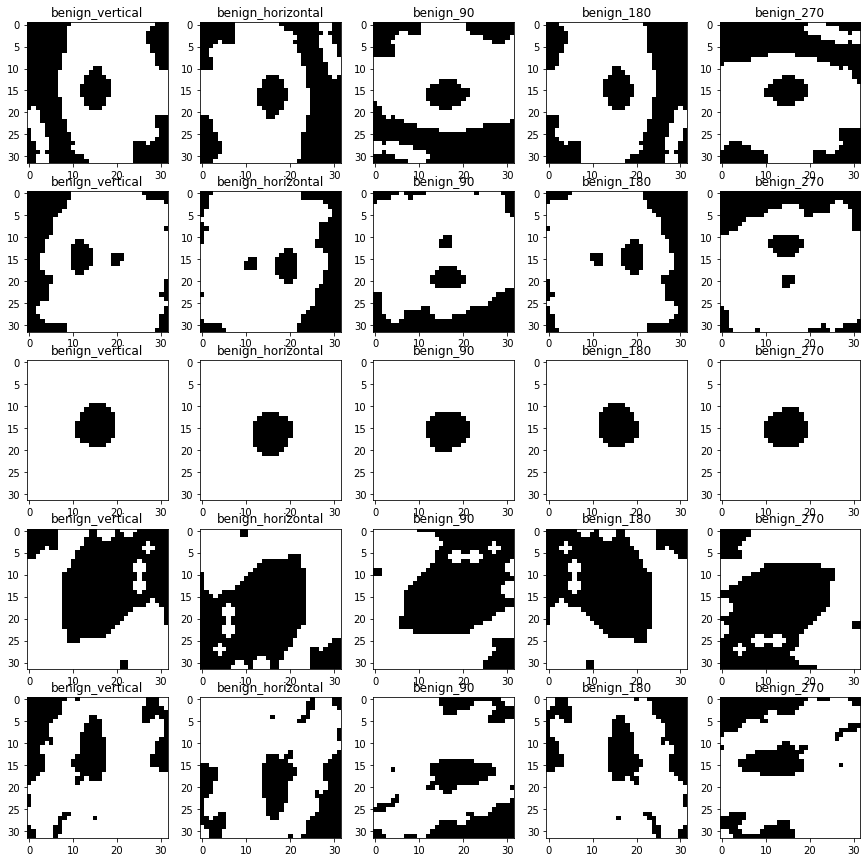

In [9]:
fig = plt.figure(figsize=(15, 15))

no_print=5
rows=no_print
columns=5

ax = []

for i in range(rows*columns):
#for i in range(len(image_augment)):
    ax.append( fig.add_subplot(rows, columns, i+1) )
    
    ax[-1].set_title(Rotate_title[i])
    plt.imshow(Rotate_array[i],cmap='gray')
    #plt.show()

0 0.0028197765350341797
10000 15.164323806762695
20000 30.479179859161377
30000 45.212445974349976


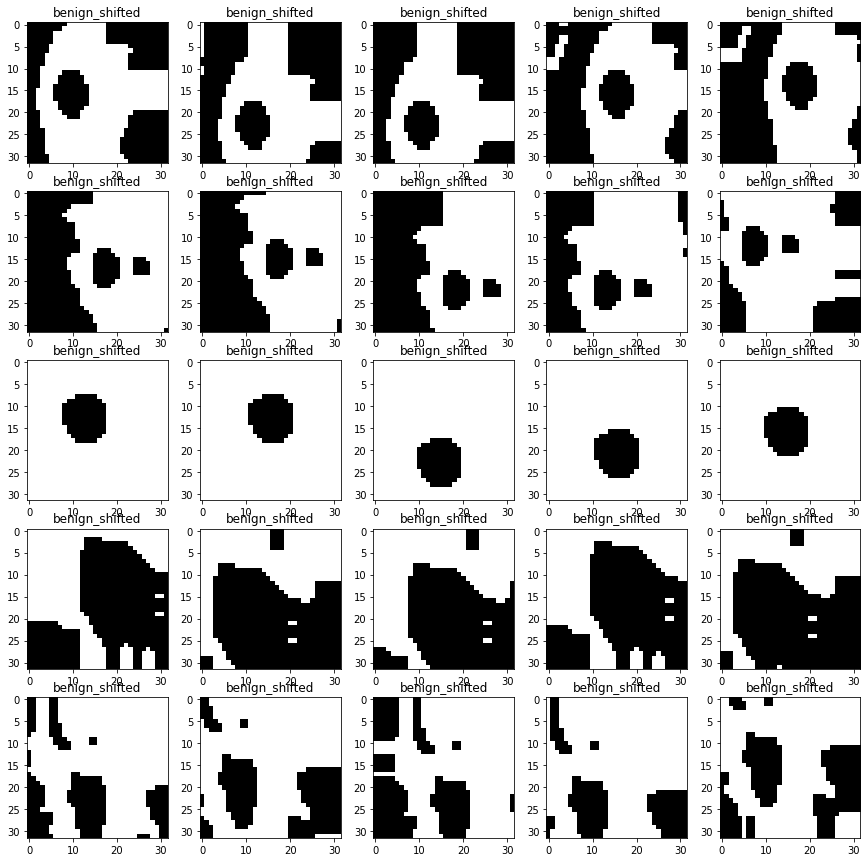

In [10]:
shift=0.2 
Num_shift=5
datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)

Shifted_image_label=[]  ##whether its bengin or malignant
Shifted_image_array=[]  #Rotated array
Shifted_image_title=[] 
Shifted_image_name=[] 
Shifted_index=[]
start=time.time()

#for i in range(1):
for i in range(len(Dilated_image_array)):
    im=Dilated_image_array[i]  #pull dilated image
    samples=expand_dims(im,-1) #expand dimension to grayscale
    samples_expand=expand_dims(samples,0)  # expand dimension to one sample
    datagen.fit(samples_expand) # fit parameters from data

    it=datagen.flow(samples_expand, batch_size=1)
    
    orig_image_name=Dilated_image_name[i].split("/")[1]
    
    for s in range(Num_shift):
        batch = it.next()
        # convert to unsigned integers for viewing
        imageA = batch[0].astype('uint8')
        
        Shifted_image_array.append(imageA)
        Shifted_image_label.append(Dilated_image_label[i])
        Shifted_image_title.append(Dilated_image_label[i] + "_shifted")
        Shifted_image_name.append(orig_image_name)
        Shifted_index.append(i)
        
    if (i%10000)==0:
        Thousand=time.time()
        print(i,Thousand-start)     

len(Shifted_image_array)

fig = plt.figure(figsize=(15, 15))

no_print=5
rows=no_print
columns=(Num_shift)

ax = []

for i in range(rows*columns):
#for i in range(len(image_augment)):
   
    # Hide grid lines
    #ax[-1].grid(False)

    # Hide axes ticks
    #ax[-1].set_xticks([])
    #ax[-1].set_yticks([])
    
    
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title(Shifted_image_title[i])
    plt.imshow(Shifted_image_array[i],cmap='gray')
    #plt.show()

0 0.0013568401336669922
10000 2.940823793411255
20000 5.816090822219849
30000 8.86165189743042


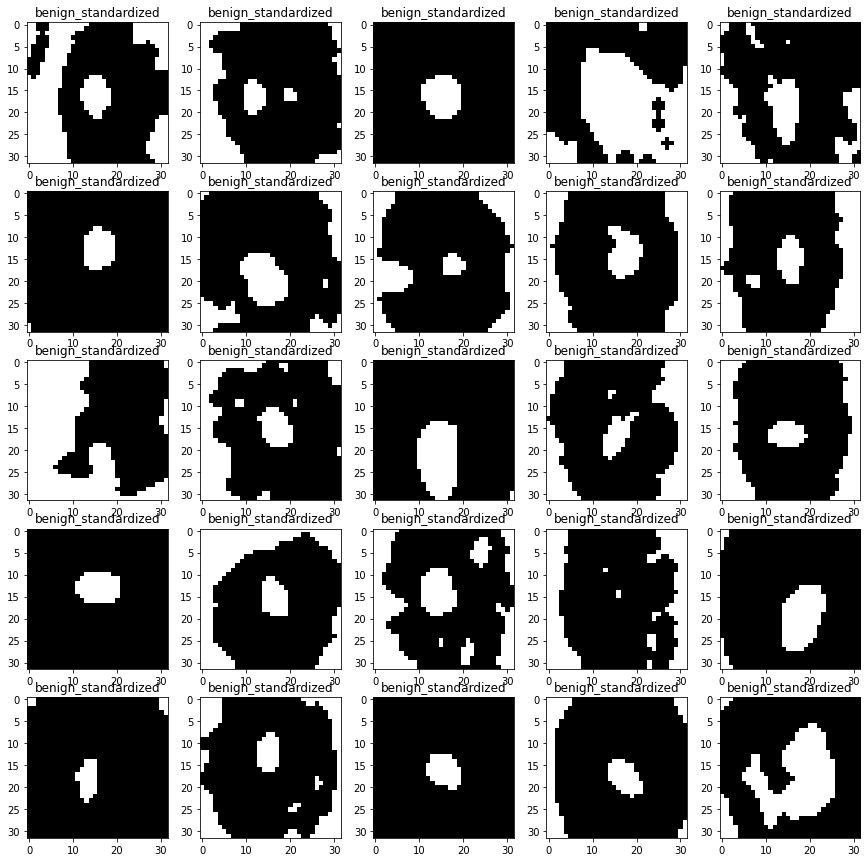

In [11]:
start=time.time()

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)   
    

Standard_image_label=[]  ##whether its bengin or malignant
Standard_image_array=[]  #Rotated array
Standard_image_title=[] 
Standard_image_name=[] 
Standard_index=[]

#for i in range(1):
for i in range(len(Dilated_image_array)):
    im=Dilated_image_array[i]  #pull dilated image
    samples=expand_dims(im,-1) #expand dimension to grayscale
    samples_expand=expand_dims(samples,0)  # expand dimension to one sample
    
    
    datagen.fit(samples_expand)  # fit parameters from data
    it=datagen.flow(samples_expand, batch_size=1)
 

    orig_image_name=Dilated_image_name[i].split("/")[1]
    
    batch = it.next()
    # convert to unsigned integers for viewing
    imageA = batch[0].astype('uint8')
        
    Standard_image_array.append(imageA)
    Standard_image_label.append(Dilated_image_label[i])
    Standard_image_title.append(Dilated_image_label[i] + "_standardized")
    Standard_image_name.append(orig_image_name)
    Standard_index.append(i)
    
    if (i%10000)==0:
        Thousand=time.time()
        print(i,Thousand-start)
        
len(Standard_image_array)

fig = plt.figure(figsize=(15, 15))

no_print=5
rows=no_print
columns=5

ax = []

for i in range(rows*columns):
#for i in range(len(image_augment)):
    ax.append( fig.add_subplot(rows, columns, i+1) )
    # Hide grid lines
    #ax[-1].grid(False)

    # Hide axes ticks
    #ax[-1].set_xticks([])
    #ax[-1].set_yticks([])

    
    ax[-1].set_title(Standard_image_title[i])
    plt.imshow(Standard_image_array[i],cmap='gray')
    #plt.show()

In [12]:
np.save("Rotated_image_array", Rotate_array)
np.save("Rotated_image_label", Rotate_label)      
np.save("Rotated_image_title", Rotate_title)
np.save("Rotated_image_name", Rotate_name)   
np.save("Rotated_index", Rotate_index)




In [13]:
np.save("Standard_image_array", Standard_image_array)
np.save("Standard_image_label", Standard_image_label)      
np.save("Standard_image_title", Standard_image_title)
np.save("Standard_image_name", Standard_image_name)   
np.save("Standard_index", Standard_index)



In [14]:
np.save("Shifted_image_array", Shifted_image_array)
np.save("Shifted_image_label", Shifted_image_label)      
np.save("Shifted_image_title", Shifted_image_title)
np.save("Shifted_image_name", Shifted_image_name) 
np.save("Shifted_index", Shifted_index)

In [15]:
Shifted_image_name[:2]

['ISIC_2637011.dcm', 'ISIC_2637011.dcm']

In [16]:
dict_dilate = {'image_name':  Dilated_name, 'image_label':Dilated_image_label,'index':range(len(Dilated_image_name))}   
df_dilated = pd.DataFrame(dict_dilate)

dict_rot = {'image_name':  Rotate_name, 'image_label':Rotate_label,'image_title':Rotate_title,'index':Rotate_index}   
df_rotated = pd.DataFrame(dict_rot)


dict_shift = {'image_name':  Shifted_image_name, 'image_label':Shifted_image_label,'image_title':Shifted_image_title,'index':Shifted_index}   
df_shifted = pd.DataFrame(dict_shift)


dict_std = {'image_name':  Standard_image_name, 'image_label':Standard_image_label,'image_title':Standard_image_title,'index':Standard_index}   
df_standard = pd.DataFrame(dict_std)

df_dilated.to_csv("Dilated_image.csv",index=False)
df_rotated.to_csv("Rotated_image.csv",index=False)
df_shifted.to_csv("Shifted_image.csv",index=False)
df_standard.to_csv("Standard_image.csv",index=False)